Columns in the DataFrame: Index(['CustomerID', 'R score', 'F score', 'M score'], dtype='object')
Number of records used in the clustering: 1000
Execution Time: 0.12 seconds
Silhouette Score: 0.71


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
<ipython-input-7-eba8bf97bd90>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(df['Cluster'].unique()))


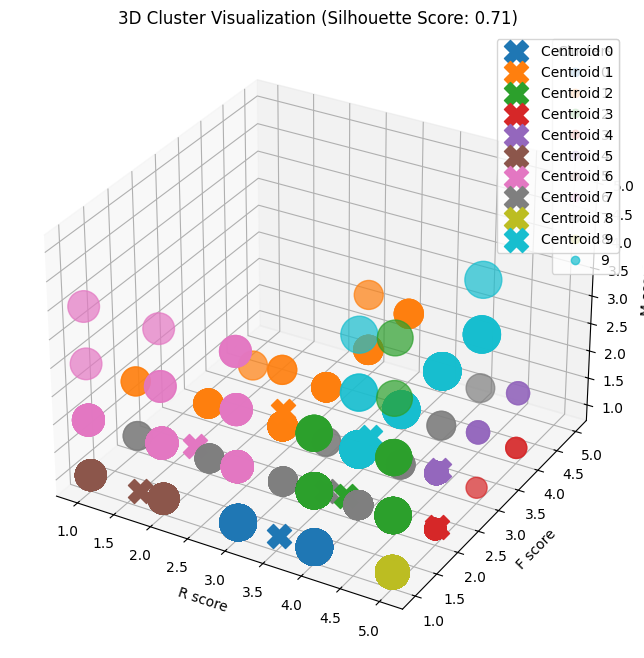

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
import time

# Start the timer
start_time = time.time()

# Function to run RM KMeans with KMeans++ initialization and Power Transformation
def rm_kmeans_kplusplus(df, n_clusters):
    # Step 1: Apply Power Transformation (Box-Cox for positive values)
    pt = PowerTransformer(method='box-cox')  # Box-Cox can handle positive values only
    df[['Transformed R score', 'Transformed F score', 'Transformed M score']] = pt.fit_transform(
        df[['R score', 'F score', 'M score']]
    )

    # Step 2: Initialize KMeans++ with more initializations to ensure centroid spread
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,  # Increase the number of initializations for better centroid spread
        max_iter=300,
        random_state=42
    )
    kmeans.fit(df[['Transformed R score', 'Transformed F score', 'Transformed M score']])

    # Step 3: Add the cluster labels to the original DataFrame
    df['Cluster'] = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(
        df[['Transformed R score', 'Transformed F score', 'Transformed M score']],
        kmeans.labels_
    )

    return kmeans, df, silhouette_avg, pt

# Function to plot clusters in 3D (non-interactive) with size proportional to cluster size
def plot_clusters_3d(df, kmeans, silhouette_avg, pt):
    # Prepare the centroids in the original scale
    transformed_centroids = pt.inverse_transform(kmeans.cluster_centers_)

    # Count the number of records in each cluster
    cluster_sizes = df['Cluster'].value_counts().sort_index()

    # Scale factor for point sizes (proportional to the number of records in the cluster)
    scale_factor = 5  # Reduced this factor for smaller points
    sizes = df['Cluster'].map(cluster_sizes) * scale_factor

    # Create a non-interactive 3D scatter plot using Matplotlib
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define the color map
    cmap = plt.cm.get_cmap('tab10', len(df['Cluster'].unique()))

    # Plot the clusters
    scatter = ax.scatter(
        df['R score'], df['F score'], df['M score'],
        c=df['Cluster'], cmap=cmap, s=sizes, alpha=0.7
    )

    # Plot the centroids with the same color as the cluster points
    for i, centroid in enumerate(transformed_centroids):
        ax.scatter(
            centroid[0], centroid[1], centroid[2],
            s=300, c=[cmap(i)], marker='X', label=f'Centroid {i}'
        )

    # Labels and title
    ax.set_xlabel('R score')
    ax.set_ylabel('F score')
    ax.set_zlabel('M score')
    ax.set_title(f'3D Cluster Visualization (Silhouette Score: {silhouette_avg:.2f})')

    # Create color legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    # Show the legend for centroids
    ax.legend()

    # Display the plot
    plt.show()

# Load the preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/Online Retail Preprocessed.csv')

# Print the column names to debug
print("Columns in the DataFrame:", df.columns)

# Check the number of records
num_records = df.shape[0]
print(f'Number of records used in the clustering: {num_records}')

# Define the number of clusters
n_clusters = 10  # You can adjust this value

#####################################################################

# Run RM K-Means with KMeans++
kmeans_model, clustered_df, silhouette_avg, pt = rm_kmeans_kplusplus(df, n_clusters)

# End the timer
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

# Display the silhouette score
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Plot the clusters in 3D with centroids properly placed and matching colors
plot_clusters_3d(clustered_df, kmeans_model, silhouette_avg, pt)


######################


Combination: ('R score',), Transformations: ('none',), Silhouette Score: 0.476
Combination: ('R score',), Transformations: ('box-cox',), Silhouette Score: 0.443
Combination: ('R score',), Transformations: ('log',), Silhouette Score: 0.720
Combination: ('F score',), Transformations: ('none',), Silhouette Score: 0.476
Combination: ('F score',), Transformations: ('box-cox',), Silhouette Score: 0.485
Combination: ('F score',), Transformations: ('log',), Silhouette Score: 0.452
Combination: ('M score',), Transformations: ('none',), Silhouette Score: 0.476
Combination: ('M score',), Transformations: ('box-cox',), Silhouette Score: 0.559
Combination: ('M score',), Transformations: ('log',), Silhouette Score: 0.656
Combination: ('R score', 'F score'), Transformations: ('none', 'none'), Silhouette Score: 0.476
Combination: ('R score', 'F score'), Transformations: ('none', 'box-cox'), Silhouette Score: 0.485
Combination: ('R score', 'F score'), Transformations: ('none', 'log'), Silhouette Score:

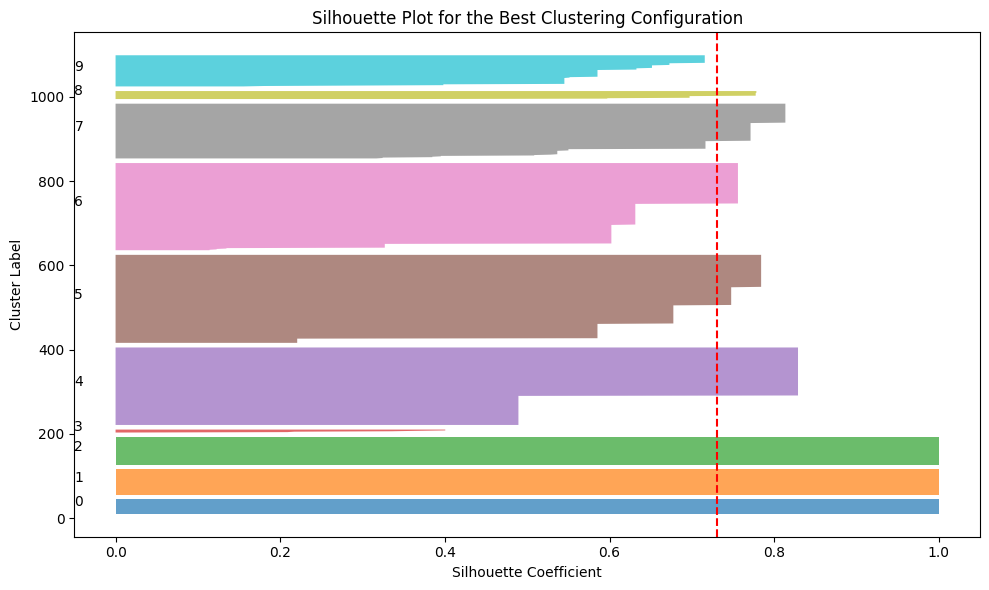

Lambda values for Box-Cox transformations: {'F score': array([-1.56719464])}


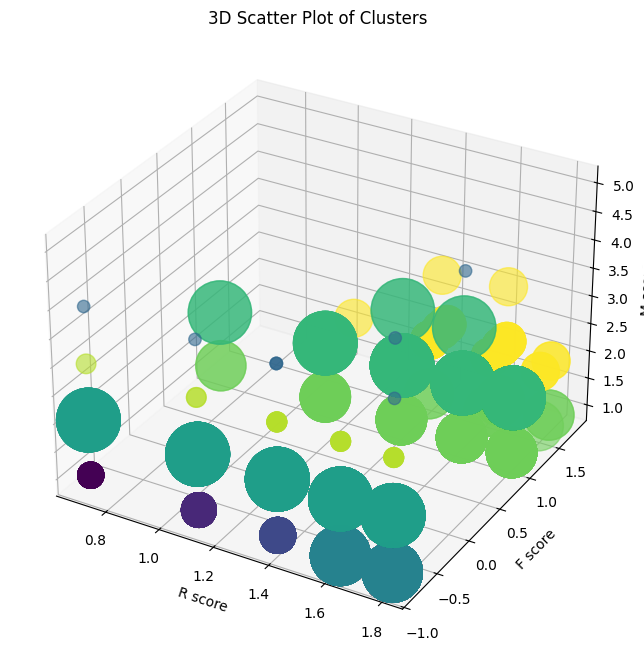

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import PowerTransformer
import itertools

# Define the rm_kmeans function
def rm_kmeans(df, n_clusters, columns_to_transform, transformations):
    # Create a copy of the DataFrame to preserve the original data
    df_transformed = df.copy()
    lambdas = {}  # Dictionary to store lambda values for Box-Cox transformation

    # Apply transformations based on the transformations dictionary
    for col, transformation in zip(columns_to_transform, transformations):
        if transformation == 'box-cox':
            pt = PowerTransformer(method='box-cox')
            df_transformed[col] = pt.fit_transform(df_transformed[[col]])
            lambdas[col] = pt.lambdas_  # Store lambda value for Box-Cox
        elif transformation == 'log':
            df_transformed[col] = np.log1p(df_transformed[col])  # Apply log transformation (log1p handles 0s)

    # Step 3: Sort each transformed column
    R_sorted = np.sort(df_transformed['R score'].values)
    F_sorted = np.sort(df_transformed['F score'].values)
    M_sorted = np.sort(df_transformed['M score'].values)

    # Step 4: Split each sorted vector into 'n_clusters' segments
    segment_size = len(df_transformed) // n_clusters

    # Step 5: Calculate the median for each segment
    initial_centroids = []
    for i in range(n_clusters):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < n_clusters - 1 else len(df_transformed)  # Ensure all data is included

        r_median = np.median(R_sorted[start_idx:end_idx])
        f_median = np.median(F_sorted[start_idx:end_idx])
        m_median = np.median(M_sorted[start_idx:end_idx])

        initial_centroids.append([r_median, f_median, m_median])

    initial_centroids = np.array(initial_centroids)

    # Step 6: Initialize KMeans with these initial centroids and fit the model
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, max_iter=300, random_state=42)
    kmeans.fit(df_transformed[['R score', 'F score', 'M score']])

    # Step 7: Calculate silhouette score
    silhouette_avg = silhouette_score(df_transformed[['R score', 'F score', 'M score']], kmeans.labels_)

    # Silhouette samples for plotting
    sample_silhouette_values = silhouette_samples(df_transformed[['R score', 'F score', 'M score']], kmeans.labels_)

    # Add cluster labels to the DataFrame
    df_transformed['Cluster'] = kmeans.labels_

    return silhouette_avg, sample_silhouette_values, lambdas, kmeans, df_transformed

# Load the preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/Online Retail Preprocessed.csv')

# Define the number of clusters
n_clusters = 10

# List of all columns to consider for transformations
columns = ['R score', 'F score', 'M score']

# Store the silhouette scores for different transformations
silhouette_scores = {}

# Define possible transformations
transformations_options = ['none', 'box-cox', 'log']

# Generate all possible combinations of transformations (1 to 3 columns, each with one of the possible transformations)
for num_columns in range(1, 4):  # 1, 2, or all 3 attributes
    for combination in itertools.combinations(columns, num_columns):
        for transformations in itertools.product(transformations_options, repeat=num_columns):
            # Apply the transformations to the selected columns
            silhouette_avg, _, _, _, _ = rm_kmeans(df, n_clusters, combination, transformations)
            silhouette_scores[(combination, transformations)] = silhouette_avg

# Print the silhouette scores for all combinations
for (combination, transformations), score in silhouette_scores.items():
    print(f"Combination: {combination}, Transformations: {transformations}, Silhouette Score: {score:.3f}")

# Find the best combination with the highest silhouette score
best_combination = max(silhouette_scores, key=silhouette_scores.get)
print(f"Best combination of transformations: {best_combination[0]} with transformations: {best_combination[1]} and Silhouette Score: {silhouette_scores[best_combination]:.3f}")

# Retrieve the best kmeans model, silhouette values, lambda values, and cluster labels for the best transformation
best_silhouette_avg, best_sample_silhouette_values, best_lambdas, best_kmeans, best_df_transformed = rm_kmeans(
    df, n_clusters, best_combination[0], best_combination[1])

# Print clusters along with the corresponding data
print("\nCluster Assignments:")
for cluster_num in range(n_clusters):
    cluster_data = best_df_transformed[best_df_transformed['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num}:")
    print(cluster_data[['CustomerID', 'R score', 'F score', 'M score']])

# Plot the silhouette plot
plt.figure(figsize=(10, 6))
plt.title("Silhouette Plot for the Best Clustering Configuration")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")

# Create a silhouette plot for all samples
plt.axvline(x=best_silhouette_avg, color="red", linestyle="--")
y_lower = 10
for i in range(n_clusters):
    cluster_silhouette_values = best_sample_silhouette_values[best_kmeans.labels_ == i]
    cluster_silhouette_values.sort()
    size_cluster = len(cluster_silhouette_values)
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(
        np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7
    )
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper + 10

plt.tight_layout()
plt.show()

# Print lambda values for Box-Cox transformation
print(f"Lambda values for Box-Cox transformations: {best_lambdas}")

# Create a 3D scatter plot of the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract cluster data for plotting
x = best_df_transformed['R score']
y = best_df_transformed['F score']
z = best_df_transformed['M score']
cluster_labels = best_df_transformed['Cluster']

# Calculate size of points (proportional to the number of records in each cluster)
point_sizes = best_df_transformed.groupby('Cluster').size().reindex(cluster_labels).values

# Scatter plot
scatter = ax.scatter(x, y, z, c=cluster_labels, cmap='viridis', s=point_sizes*10, alpha=0.6)  # *10 for better visualization

# Labels and title
ax.set_xlabel('R score')
ax.set_ylabel('F score')
ax.set_zlabel('M score')
ax.set_title('3D Scatter Plot of Clusters')

# Show the plot
plt.show()


In [9]:
#dbi value
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin index
db_index = davies_bouldin_score(best_df_transformed[['R score', 'F score', 'M score']], best_kmeans.labels_)

# Print the Davies-Bouldin index
print(f"Davies-Bouldin Index: {db_index:.3f}")


Davies-Bouldin Index: 0.455
